In [1]:
import pandas as pd
import tweepy
import csv
import json


ACCESS_TOKEN = ''
ACCESS_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET =''

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)

c = tweepy.Cursor(api.search, q='coronavirus', lang='en')

count=201
page_needed=int(count/15) + 3 
c.pages(page_needed)

id_tweets = []
date = []
full_text_tweet =[]
for tweet in c.items():
    try:
        tweet = api.get_status(tweet.id, count=200, tweet_mode="extended")
        full_text_tweet.append(tweet.full_text)
        id_tweets.append(tweet.id)
    except:
        pass
    if len(full_text_tweet)==count: 
        break       
print("Total Data length", len(full_text_tweet))

Total Data length 201


In [2]:
from sklearn.externals import joblib 
import string
import re
import pickle
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [3]:
tweets = pd.Series(full_text_tweet)

In [4]:

HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "




def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]


    

class TextPreProc(BaseEstimator,TransformerMixin):
    def __init__(self, use_mention=False):
        self.use_mention = use_mention
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # We can choose between keeping the mentions
        # or deleting them
        if self.use_mention:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", " @tags ")
        else:
            X = X.str.replace(r"@[a-zA-Z0-9_]* ", "")
            
        # Keeping only the word after the #
        X = X.str.replace("#", "")
        X = X.str.replace(r"[-\.\n]", "")
        # Removing HTML garbage
        X = X.str.replace(r"&\w+;", "")
        # Removing links
        X = X.str.replace(r"https?://\S*", "")
        # replace repeated letters with only two occurences
        # heeeelllloooo => heelloo
        X = X.str.replace(r"(.)\1+", r"\1\1")
        # mark emoticons as happy or sad
        X = X.str.replace(HAPPY_EMO, " happyemoticons ")
        X = X.str.replace(SAD_EMO, " sademoticons ")
        X = X.str.lower()
        return X



In [5]:
#Random Forest Model
SVC_model = joblib.load('SVC_MODEL.pkl')
#Feature Vector
with open('RF_SVC_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.1 when using version 0.20.3. This might l

In [6]:
tweets = tokenizer.transform(tweets)

C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [7]:
pos_count=0
neg_count=0
neutral_count=0

In [8]:
sentiments=[]
for i in range(len(full_text_tweet)):
    result=SVC_model.predict_proba(tweets[i])[0]
    if result[0] > 0.60:
        sentiments.append("😃")
        pos_count = pos_count+1

        #print("Text : " + full_text_tweet[i] + " Sentiment : 😃")
    elif result[0] < 0.40:
        sentiments.append("😔")
        neg_count = neg_count+1
        #print("Text : " + full_text_tweet[i] + " Sentiment : 😔")
    else:
        sentiments.append("😐")
        neutral_count=neutral_count+1

        #print("Text : " + full_text_tweet[i] + " Sentiment : 😐")
sentiments = pd.Series(sentiments, name="Sentiment")
full_text_tweet = pd.Series(full_text_tweet, name="Tweet")        
result_dataframe = pd.concat([full_text_tweet, sentiments], axis=1)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

C:\Users\Mert\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [9]:
result_dataframe

,Tweet,Sentiment
0,RT @puzzlesandgames: FOLLOW US and RETWEET this post for a chance to WIN THIS PUZZLE BOOK! We will #giveaway a puzzle book every day until…,😔
1,"RT @anniekarni: This came just days after Mulvaney said the media was hyping coronavirus, ""they think this will bring down the president, t…",😐
2,"RT @maddow: University of Washington IHME new forecast:\n\nOver 200,000 Americans dead from coronavirus by October 1:\n\nhttps://t.co/YdkMASF6UL",😃
3,Marketing in the middle of a global crisis | https://t.co/yCp1sVm5Im by Rirhandzu Shingwenyana via @Biz_Marketing #Covid19 #coronavirus #lockdown #pandemic #marketing,😔
4,"RT @draayyy09: Trump on coronavirus: ""If we stop testing right now, we'd have very few cases.\n\nI agree😂😂😂💔💔💔🤝🤝🤝",😔
5,RT @EffMktHype: Just to recap:\nCoronavirus 2nd wave potentially rolling in\nIndia and China skirmish with fatalities\nExplosive escalation at…,😐
6,RT @theharpoonman: Roberts joins liberals as Supreme Court rejects challenge to coronavirus limits on church services https://t.co/y8bcOdSA…,😔
7,RT @aubrey_huff: I will no longer wear a mask inside any business. It’s unconstitutional to enforce. Let’s make this bullshit stop now! Who…,😐
8,RT @kwelijournal: Sending condolences and light to Rep. Ilhan Omar and family. \n\nRep. Ilhan Omar's Father Dies Due to Coronavirus\n\nhttps://…,😃
9,#SARS-CoV-2 genome sequencing is ramping up to aid genomic epidemiology. On the #MicroBinfie podcast we chat to @Justin_OGrady about his experiences with going from 0 to 1500 genomes in 2 months.\nSpotify: https://t.co/VmYsYbdwz0\nSoundcloud: https://t.co/E8K6UTznqf,😃


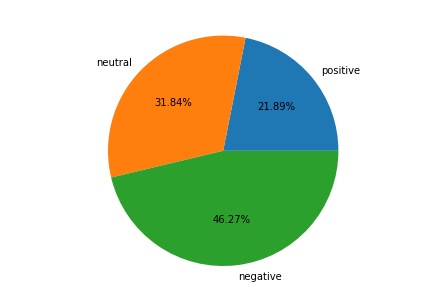

In [10]:
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['positive', 'neutral', 'negative']
prediction = [pos_count,neutral_count,neg_count]
ax.pie(prediction, labels = langs,autopct='%1.2f%%')
plt.show()